<a href="https://colab.research.google.com/github/Nazhan99/Tensorflow_notes/blob/main/05_Transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer learning with TensorFlow part 2: Fine-Tuning

In [1]:
!nvidia-smi

Tue Feb 22 06:13:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Creating helper function

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-02-22 06:13:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-22 06:13:02 (88.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
#import helper function we are going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data,  walk_through_dir

>if you are running this notebook in Google colab, when it times out colab will delete "helper_function".

## Get some data

use pretrained model using tf.keras.application and apply them to our own probelm (recognizing images of food).

In [4]:
# get 10% of training data of 10 fooc classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-02-22 06:13:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  48.1MB/s    in 3.3s    

2022-02-22 06:13:09 (48.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
#check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [6]:
#create training and test directories paths
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"


In [7]:
import tensorflow as tf

IMG_SIZE=(224,224)
BATCH_SIZE=32

train_data_10_percent= tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)

test_data_10_percent= tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
#check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
#see an example of a batch of data
for image, labels in train_data_10_percent.take(1):
  print(image,labels)

#need to normalize these tensors later

tf.Tensor(
[[[[1.06357140e+02 5.43571434e+01 5.83571434e+01]
   [1.05071426e+02 5.30714264e+01 5.70714264e+01]
   [1.03285713e+02 5.32857132e+01 5.58571396e+01]
   ...
   [1.65846893e+02 1.83418365e+02 1.83418365e+02]
   [1.66642868e+02 1.84642868e+02 1.84642868e+02]
   [1.67897980e+02 1.87897980e+02 1.86897980e+02]]

  [[1.08882652e+02 5.38826523e+01 5.88826523e+01]
   [1.05209183e+02 5.29948997e+01 5.70663261e+01]
   [1.01071426e+02 5.09591827e+01 5.40153046e+01]
   ...
   [1.64974487e+02 1.82545959e+02 1.82331696e+02]
   [1.68214294e+02 1.86214294e+02 1.86214294e+02]
   [1.66734650e+02 1.86734650e+02 1.87734650e+02]]

  [[1.02576530e+02 5.53520393e+01 5.80000000e+01]
   [9.98979568e+01 5.52142868e+01 5.81836739e+01]
   [9.69030609e+01 5.43826523e+01 5.90000000e+01]
   ...
   [1.67020447e+02 1.84591919e+02 1.84377655e+02]
   [1.64729584e+02 1.82729584e+02 1.83158157e+02]
   [1.68352173e+02 1.88352173e+02 1.89352173e+02]]

  ...

  [[1.61637756e+02 9.22805557e+01 6.06629086e+00]
   [1

## model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight forward, it runs our layers in sequential order.

But the functional API gives us flexibility with our models

---



In [11]:
#1. create base model with tf.keras.applications
base_model= tf.keras.applications.EfficientNetB0(include_top=False)

#2. freeze the base model (so the underlying pre trained patterns are not updating)
base_model.trainable=False

#3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

#4. If uisng Resnet50V2 you will need to normalize inputs (you dont have to for EfficientNet)
#x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. Past the input to the base_model
x=base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

#6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

#8. combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

#9. Compile for the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#10. fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=int(0.25*len(test_data_10_percent)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220222-061326
Epoch 1/5
24/24 [==============================] - 28s 453ms/step - loss: 1.8611 - accuracy: 0.4227 - val_loss: 1.3152 - val_accuracy: 0.7039
Epoch 2/5
24/24 [==============================] - 9s 358ms/step - loss: 1.1322 - accuracy: 0.7547 - val_loss: 0.8999 - val_accuracy: 0.8174
Epoch 3/5
24/24 [==============================] - 7s 267ms/step - loss: 0.8293 - accuracy: 0.8027 - val_loss: 0.7425 - val_accuracy: 0.8257
Epoch 4/5
24/24 [==============================] - 8s 308ms/step - loss: 0.6754 - accuracy: 0.8480 - val_loss: 0.6574 - val_accuracy: 0.8273
Epoch 5/5
24/24 [==============================] - 7s 266ms/step - loss: 0.5838 - accuracy: 0.8573 - val_loss: 0.5846 - val_accuracy: 0.8487


In [12]:
#evaluate on the full test dataset
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 11s 137ms/step - loss: 0.6109 - accuracy: 0.8364


[0.6108518838882446, 0.8363999724388123]

In [13]:
#check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [14]:
#how about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [15]:
#how about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


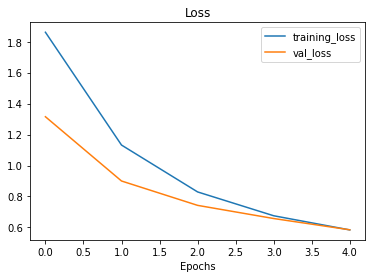

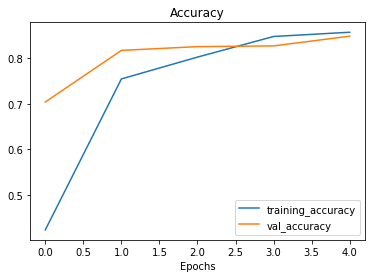

In [16]:
#check out the loss curves of the model
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through 'base model' of shape(None,7,7,1280). 

But then when it passes through GlobalAveragePooling2D, it turns into (None,1280). 

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [17]:
# Define the input shape
input_shape = (1,4,4,3)

#create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}")

#pass the random tensor through a global average pooling 2D
global_Average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_Average_pooled_tensor}")

#check the shape of the different tensors
print(f"\nShape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooled 2D: {global_Average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled 2D: (1, 3)


In [18]:
#Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments
 we have seen the incredible resuts transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

 1. 'model_1' - use feature extraction transfer learning with 1% of the training data with data augmentation
 2. 'model_2' - use feature extraction transfer learning with 10% of the training with data augmentation.
 3. 'model 3' - use fine-tuning transfer learning oon 10% of the training data with data augmentation.
 4. 'model 4' - use fine-tuning transfer learning on 100% of the training data with data augmentation.

 > **Note** throoughout all experiments the same test dataset will be used too evaluate ur model. this ensures consistency acrooss evaluation metrics.

## Getting preprocessing data

In [19]:
#Download and unzip data -preprocess from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2022-02-22 06:14:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  76.0MB/s    in 1.7s    

2022-02-22 06:14:42 (76.0 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
#create training and test dir
train_dir_1_percent= "10_food_classes_1_percent/train"
test_dir="10_food_classes_1_percent/test"

In [21]:
#how many images we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There a

In [22]:
#Setup data loaders
IMG_SIZE=(224,224)

train_data_1_percent= tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                         label_mode="categorical",
                                                                         image_size=IMG_SIZE,
                                                                         batch_size=32) 

test_data= tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE)
                                                                         

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into our model

To add data augmentation right into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()

>refer: https://www.tensorflow.org/tutorials/images/data_augmentation

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense

#from tensorflow.keras.layers.experimental import preprocessing
tf.random.set_seed(42)

#create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = tf.keras.Sequential([
                                      layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.5),
                                      layers.RandomZoom(0.5),
                                      layers.RandomHeight(0.5),
                                      layers.RandomWidth(0.5)
                                      #layers.Rescaling(1./255) # keep for model like ResNet50V2
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happers to our data)

tf.Tensor(
[[[False False False]
  [False False False]
  [False False False]
  ...
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ...
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ...
  [False False False]
  [False False False]
  [False False False]]

 ...

 [[False False False]
  [False False False]
  [False False False]
  ...
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ...
  [False False False]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]
  ...
  [False False False]
  [False False False]
  [False False False]]], shape=(382, 512, 3), dtype=bool)


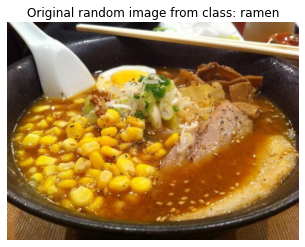

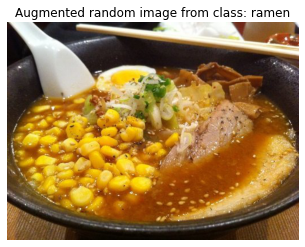

In [24]:
#View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random

target_class=random.choice(train_data_1_percent.class_names)
target_dir="10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

#read and plot in the random image
img=mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)

#plot our augmented random image
augmented_img=data_augmentation(img)/255.

plt.figure()
plt.imshow(augmented_img)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

print(img==augmented_img)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [25]:
#Setup input_shape and base model, freezing the base model layers
input_shape= (224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable= False

#create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

#add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

#give base_model the inputs (after augmentation) and dont train it
x=base_model(x, training=False)

#pool output features of the base model
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer") (x)

#make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

#compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                #track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220222-061447
Epoch 1/5
3/3 [==============================] - 15s 3s/step - loss: 2.4151 - accuracy: 0.0571 - val_loss: 2.4366 - val_accuracy: 0.0806
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.3353 - accuracy: 0.1857 - val_loss: 2.3550 - val_accuracy: 0.1168
Epoch 3/5
3/3 [==============================] - 8s 3s/step - loss: 2.0815 - accuracy: 0.2429 - val_loss: 2.2557 - val_accuracy: 0.1743
Epoch 4/5
3/3 [==============================] - 8s 3s/step - loss: 2.0065 - accuracy: 0.4000 - val_loss: 2.1956 - val_accuracy: 0.1826
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.9783 - accuracy: 0.3286 - val_loss: 2.1166 - val_accuracy: 0.2286


In [26]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (382, 512, 3)            0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [27]:
#Evaluate on the full test dataset
results_1_percent_data_aug=model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 11s 132ms/step - loss: 2.1199 - accuracy: 0.2300


[2.1199252605438232, 0.23000000417232513]

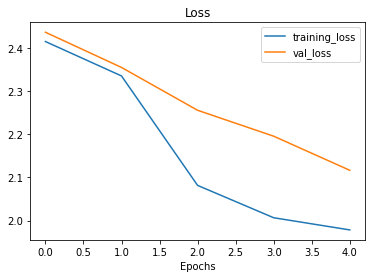

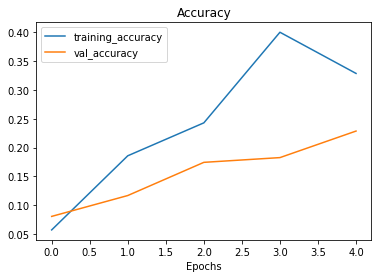

In [28]:
#plot loss curve of the model
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation.

In [29]:
train_dir_10_percent= "10_food_classes_10_percent/train"
test_dir_10_percent="10_food_classes_10_percent/test"

In [30]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [31]:
#set data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [32]:
#create model 2 with data augmentation 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#build data augmentation layer
data_augmentation = Sequential([
                                layers.RandomFlip("horizontal"),
                                layers.RandomRotation(0.2),
                                layers.RandomHeight(0.2),
                                layers.RandomWidth(0.2),
                                layers.RandomZoom(0.2)
                                #layers.Rescaling(1./255) #if you are using model ResNet50V2
], name="data_augmentation")

#setup the input shape into our model
input_shape = (224,224,3)

#create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x=data_augmentation(inputs) #augment our training images (augmentation doesnt occur on test data)
x= base_model(x,training= False) #pass augmented images to base model but keep it in inference mode, this also ensures batchnorm layers are not updated
# refer https://keras.io/guides/transfer_learning/
x=layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs= layers.Dense(10,activation="softmax", name="output_layer")(x)


model_2 = tf.keras.Model(inputs, outputs)

#compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


### creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weight) 

In [33]:
#set checkpoint path
checkpoint_path= "ten_percent_model_checkpoint_weights/checkpoint.ckpt"

#create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=False,
                                                        save_freq="epoch", #save every epoch
                                                        verbose=1)

In [38]:
### Fit the model_2 passing in the ModelCheckpoint callback
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25*len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220222-063025
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9922 - accuracy: 0.3387
Epoch 1: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 31s 881ms/step - loss: 1.9922 - accuracy: 0.3387 - val_loss: 1.4907 - val_accuracy: 0.6447
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3538 - accuracy: 0.6560
Epoch 2: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 17s 712ms/step - loss: 1.3538 - accuracy: 0.6560 - val_loss: 1.0860 - val_accuracy: 0.7385
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0572 - accuracy: 0.7427
Epoch 3: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 15s 629ms/step - loss: 1.0572 - accuracy: 0.7427 - val_loss: 0.8827 - val_accuracy: 0.7599
Epoc

In [41]:
results_10_percent_data_aug=model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 12s 142ms/step - loss: 0.7002 - accuracy: 0.8132


[0.7002434730529785, 0.8131999969482422]

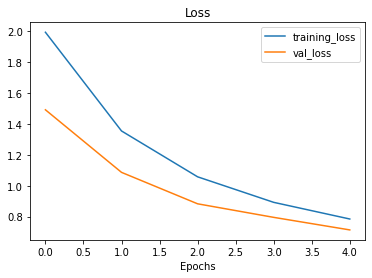

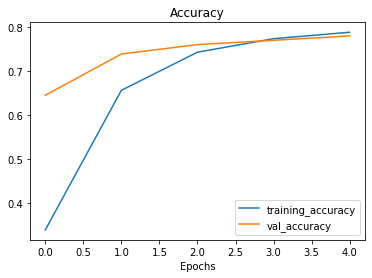

In [42]:
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weigth

Loading in checkpoint weigths returns a model to a specific checkpoint

In [43]:
#Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [45]:
#Evaluate model_2 with loaded weights
loaded_weigths_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 12s 141ms/step - loss: 0.7002 - accuracy: 0.8132


In [47]:
#if  the resutls from our previously evaluated model_2 match the loaded weights, every
results_10_percent_data_aug == loaded_weigths_model_results

False

In [48]:
results_10_percent_data_aug

[0.7002434730529785, 0.8131999969482422]

In [50]:
loaded_weigths_model_results

[0.7002432346343994, 0.8131999969482422]

In [52]:
# Check too see if loaded model results are very close to our previous non-loaded model
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weigths_model_results))

array([ True,  True])

In [56]:
#check the different between 2 results
print(np.array(results_10_percent_data_aug)- np.array(loaded_weigths_model_results))

[2.38418579e-07 0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

> Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amount of custom data

In [57]:
#layers in loaded model
model_2.layers

In [59]:
#are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fdfc89bb810> True
<keras.engine.sequential.Sequential object at 0x7fdfc9e7ff10> True
<keras.engine.functional.Functional object at 0x7fdfc99a7f10> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fdfc88b3f50> True
<keras.layers.core.dense.Dense object at 0x7fdfc8e39790> True


In [61]:
#what layers are in our base_model (EfficientNetB0) and are they trainable
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer, layer.name, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7fdfc89bb650> input_3 False
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fdfc89bbc50> rescaling_2 False
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7fdfc89bbe50> normalization_2 False
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7fdfc7999850> stem_conv_pad False
4 <keras.layers.convolutional.Conv2D object at 0x7fdfc9ec4b50> stem_conv False
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fdfc89bbcd0> stem_bn False
6 <keras.layers.core.activation.Activation object at 0x7fdfc9e93410> stem_activation False
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7fdfc9e9fb90> block1a_dwconv False
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fdfc9df9a10> block1a_bn False
9 <keras.layers.core.activation.Activation object at 0x7fdfc9e9e8d0> block1a_activation False
10 <keras.layers.pooling.GlobalAveragePooli

In [62]:
#how many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [66]:
#To begin fine-tuning, lets start by setting the last 10 layers of our base_model.trainable= True
base_model.trainable = True

#Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

#recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), #when fine-tuning you typically want to lower teh learning rate by 10x*
                metrics=["accuracy"])



> **Note** when using fine-tuning it is best practice to lower ur leaning rate by some amount. this is a hyperparameter you can tune but a good rule of thumb is atleast 10x (though different sources will claim other values).
source: https://arxiv.org/abs/1801.06146

In [68]:
#check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [69]:
#now we unfrozen some of the layers closer to the top, how many trainable variables
print(len(model_2.trainable_variables))

12


In [70]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,